<a href="https://www.kaggle.com/code/karan842/brain-tumor-detection-keras-w-b?scriptVersionId=119448352" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Brain Tumor Detection by using MRI Images and lets ask questions to ChatGPT🧠🩺

# PROJECT IS UNDER CONSTRUCTION

In [8]:
from IPython.display import clear_output
!pip install imutils
clear_output()


In [9]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,BatchNormalization, MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

sns.set_style('darkgrid')
%matplotlib inline
init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

RANDOM_SEED = 101


## Dataset

- `NO` - no tumor, encoded as `0`
- `YES` - tumor, encoded as `1`

 Right now all images are in one folder with yes and no subfolders. I will split the data into train, val and test folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [10]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── TEST
│   ├── NO
│   └── YES
├── TEST_CROP
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
├── TRAIN_CROP
│   ├── NO
│   └── YES
├── VAL
│   ├── NO
│   └── YES
└── VAL_CROP
    ├── NO
    └── YES

18 directories


In [11]:
IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n<0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/' + CLASS.upper() + '/' + FILE_NAME)

## Data import and Preprocessing

In [12]:
def load_data(dir_path, img_size=(100,100)):
    X = []
    y = []
    i=0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [13]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _  = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 45.51it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 18.09it/s]

50 images loaded from VAL/ directory.


## Distribution of classes among sets:

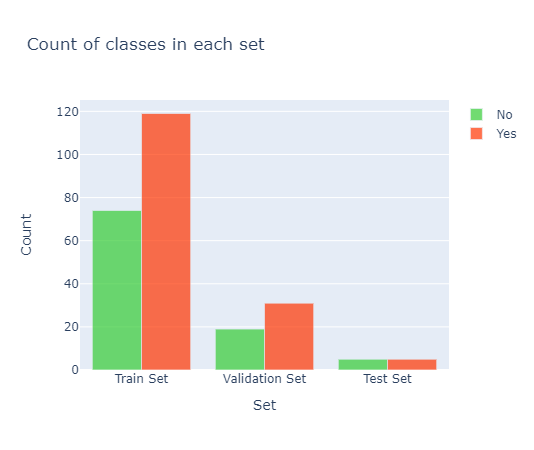

In [14]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name==0))
    y[1].append(np.sum(set_name==1))
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title':'Set'},
    yaxis={'title':'Count'}
)
fig = go.Figure(data,layout)
iplot(fig)

## Plot samples

In [15]:
def plot_samples(X,y,labels_dict, n=50):
    """
        Create a gridplot for desired number of images (n) from specified set
    """ 
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y==index)][:n]
        j = 10
        i = int(n/j)
        
        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])
            
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

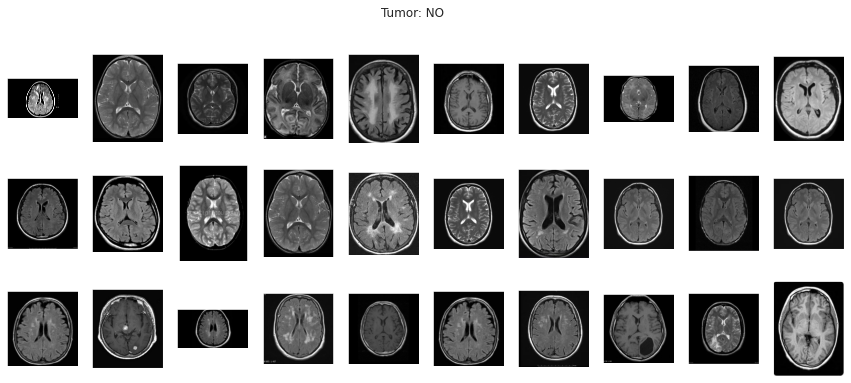

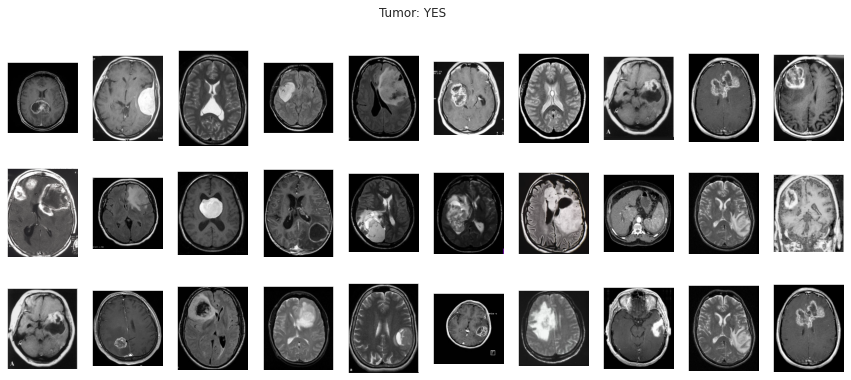

In [16]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different width and height and diffent size of "black corners". Since the image size for VGG-16 input layer is (224,224) some wide images may look weird after resizing. Histogram of ratio distributions (ratio = width/height):

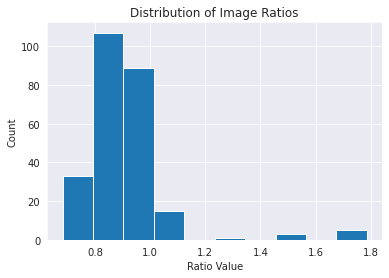

In [17]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show();

The first step of "normalization" would be to crop the brain out of the images.

`Erosion is an operation that erodes away the boundaries of foreground objects. It is performed by applying a structuring element (kernel) to the image and replacing the central pixel of the kernel with the minimum value of the pixels under the kernel. This reduces the size of the foreground objects and eliminates small white pixels (noise) from the image.

Dilation is the opposite of erosion. It expands the boundaries of the foreground objects by replacing the central pixel of the kernel with the maximum value of the pixels under the kernel. This increases the size of the foreground objects and fills small holes in the objects.`

In [18]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [19]:
img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

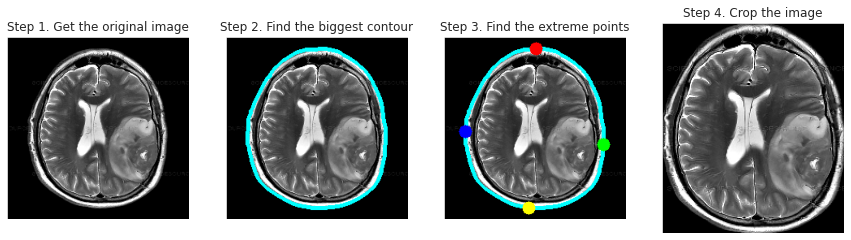

In [20]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')

plt.show();

In [21]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

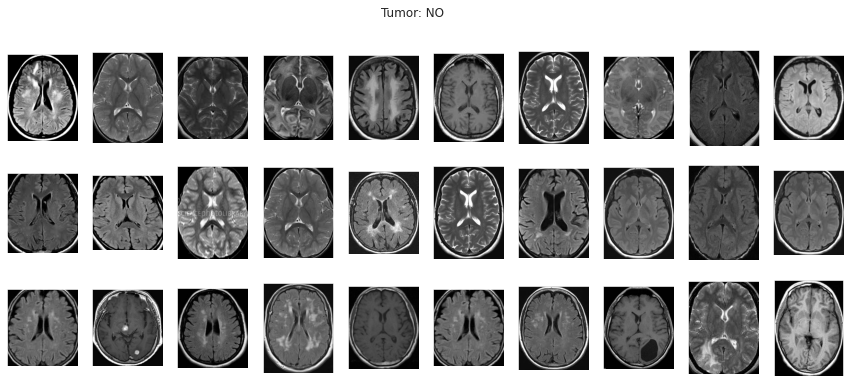

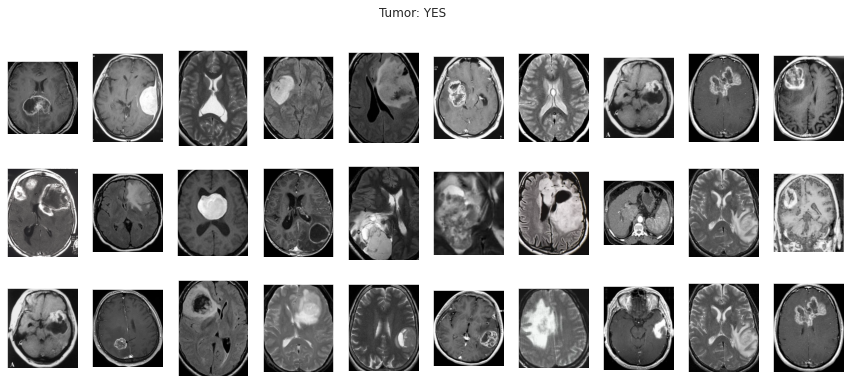

In [22]:
plot_samples(X_train_crop, y_train, labels, 30)

In [23]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [24]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


The next step would be resizing images to (224,224) and applying preprocessing needed for VGG-16 model input

In [25]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [26]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

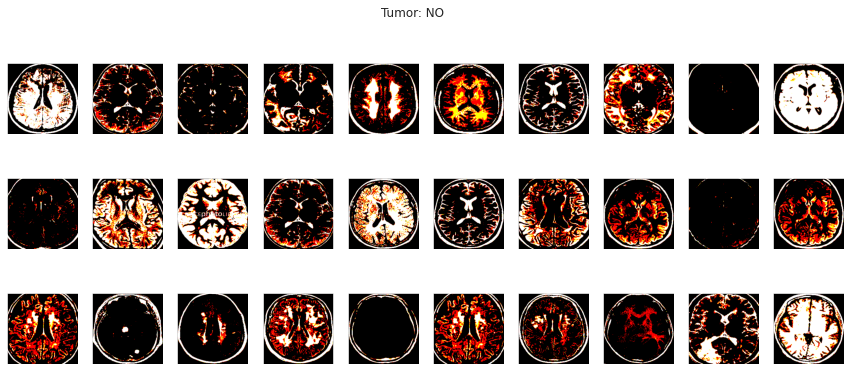

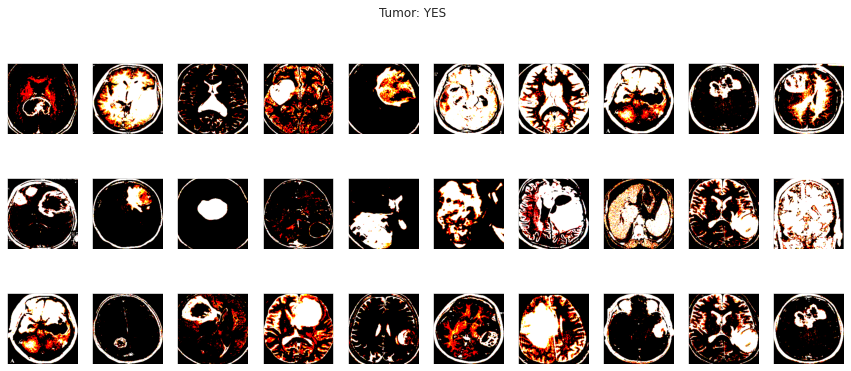

In [27]:
plot_samples(X_train_prep,y_train,labels,30)

# Pre-preocssing the data for CNN

## Data Augmentation

In [28]:
demo_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    rescale = 1./255,
    shear_range = 0.05,
    brightness_range = [0.1,1.5],
    horizontal_flip = True,
    vertical_flip = True
)

In [29]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

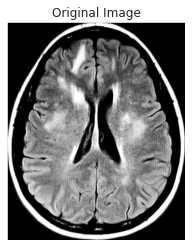

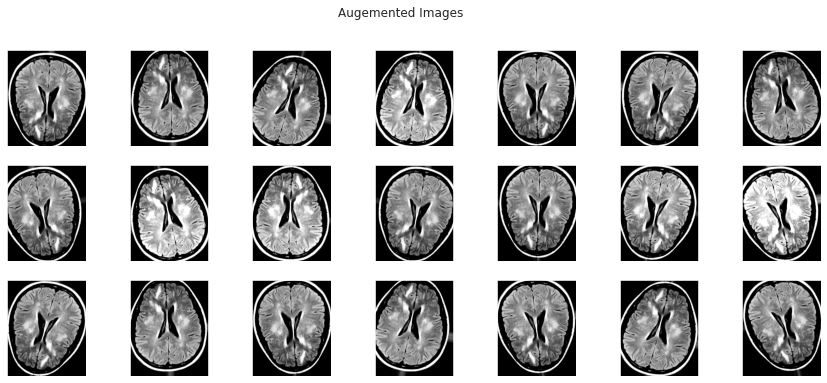

In [30]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.show()

plt.figure(figsize=(15,6))
i=1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/'+ img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i>3*7:
        break
plt.suptitle('Augemented Images')
plt.show()
    

In [31]:
!rm -rf preview/

### Applying Augmentation

In [32]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

yes_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/'
no_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'

# Get the list of all images in both directories
yes_files = [os.path.join(yes_dir, f) for f in os.listdir(yes_dir) if f.endswith('.jpg')]
no_files = [os.path.join(no_dir, f) for f in os.listdir(no_dir) if f.endswith('.jpg')]

image_files = yes_files + no_files

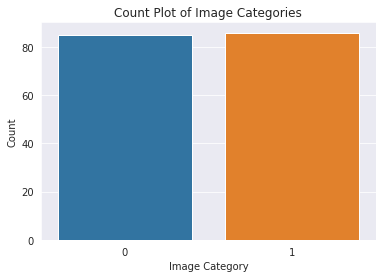

In [33]:
# Create a list of labels based on the image categories
labels = [0 if 'no' in image else 1 for image in image_files]

# Plot the count plot
sns.countplot(labels)

# Add labels and title to the plot
plt.xlabel('Image Category')
plt.ylabel('Count')
plt.title('Count Plot of Image Categories')

# Show the plot
plt.show();

## Splitting data into train and test

In [34]:
def load_data(directory):
    images = []
    labels = []
    for label in ['yes','no']:
        label_dir = os.path.join(directory,label)
        for file in os.listdir(label_dir):
            if file.endswith(".jpg"):
                file_path = os.path.join(label_dir,file)
                images.append(tf.keras.preprocessing.image.img_to_array(
                    tf.keras.preprocessing.image.load_img(file_path)
                ))
                labels.append(label)
    return np.array(images), np.array(labels)
    
images, labels = load_data("/kaggle/input/brain-mri-images-for-brain-tumor-detection/")

In [35]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

In [36]:
y_train

array(['yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no',
       'no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no',
       'no', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'yes',
       'no', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no',
       'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no',
       'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no',
       'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'yes',
       'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'no',
       'yes', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'yes',
       'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes',
       'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes',
       'no', 'no', 'no', 'no', 'yes', 'yes'], dtype='<U3')

## Data Preprocessing

In [37]:
label_map = {"yes":1,"no":0}

y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])
y_test[:5]

array([0, 1, 0, 0, 1])

`binary_crossentropy` loss function in Keras is trying to cast a string data type to a float, which is not supported.

This error is likely caused by the presence of non-numeric values in your input data. Before passing your input data to the model, make sure to remove any non-numeric values or convert them to numeric values. You can use the numpy library's isnan function to check for any NaN (Not a Number) values in your data and replace them with a suitable value.

In [38]:
X_train = np.array([cv2.resize(img,(224,224)) for img in X_train])
X_test = np.array([cv2.resize(img,(224,224)) for img in X_test])

In [39]:
X_train[0].shape, X_test[0].shape

((224, 224, 3), (224, 224, 3))

In [40]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    rescale = 1./255,
    shear_range = 0.05,
    brightness_range = [0.1,1.5],
    horizontal_flip = True,
    vertical_flip = True
)

In [41]:
datagen.fit(X_train)

In [42]:
IMG_SHAPE = X_train[0].shape
IMG_SHAPE

(224, 224, 3)

## Model Building

> Batch Normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing number of training epochs required to train 

# ChatGPT questions:

### What are the pros and cons of using `BatchNormalization`

Batch normalization is a technique used in deep learning to normalize the activations of a layer across a batch of input data, so that the mean and variance of the activations remain the same across different batches. Batch normalization can help to stabilize the training process and reduce the risk of overfitting, especially in deep neural networks with many layers.

However, there are situations where batch normalization may not be necessary or even harmful. Here are some factors to consider when deciding whether to use batch normalization:

- Network depth: Batch normalization is particularly useful for deep neural networks with many layers, as it can help prevent the -vanishing or exploding gradients problem.

- Data size: If you have a small amount of training data, batch normalization may not be necessary as the model is likely to overfit even without batch normalization.

- Model stability: Batch normalization can make the training process more stable, but it can also slow down the training process, as normalizing the activations across a batch adds computational overhead.

- Data distribution: If your input data has a highly non-uniform distribution, batch normalization may not be effective, as the normalization will be based on the mean and variance of each batch, which may not accurately reflect the distribution of the entire dataset.

In general, it's a good idea to try both with and without batch normalization, and compare the performance of your model on your validation set to determine whether batch normalization is beneficial for your problem. If you find that batch normalization is slowing down your training process without improving performance, you may consider not using it.

In [43]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=IMG_SHAPE))
model.add(Conv2D(64, kernel_size=3, activation='relu',padding='Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = 3, activation ='relu', padding = 'Same'))
model.add(Conv2D(128, kernel_size = 3, activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

2023-02-17 09:03:45.816111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 09:03:45.817186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 09:03:45.966738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 09:03:45.967694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 09:03:45.968617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [44]:
# Run 
import wandb
from wandb.keras import WandbCallback
run = wandb.init(project='brain-tumor-detection',
                config={ # include hyperparameters and metadata
                    "learning_rate":0.001,
                    "epochs":100,
                    "loss_function":"binary_crossentropy",
                    "architecture":"CNN-TUMOR",
                    "dataset":""
                    
                })
config = wandb.config # we will use this to configure our experiment
tf.keras.backend.clear_session()

# Compiling model
optimizer = tf.keras.optimizers.Adam(config.learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer,config.loss_function,metrics=['accuracy'])

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ·······················································


wandb: ERROR API key must be 40 characters long, yours was 55
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     7

#### Pictorial representation of `model summary`

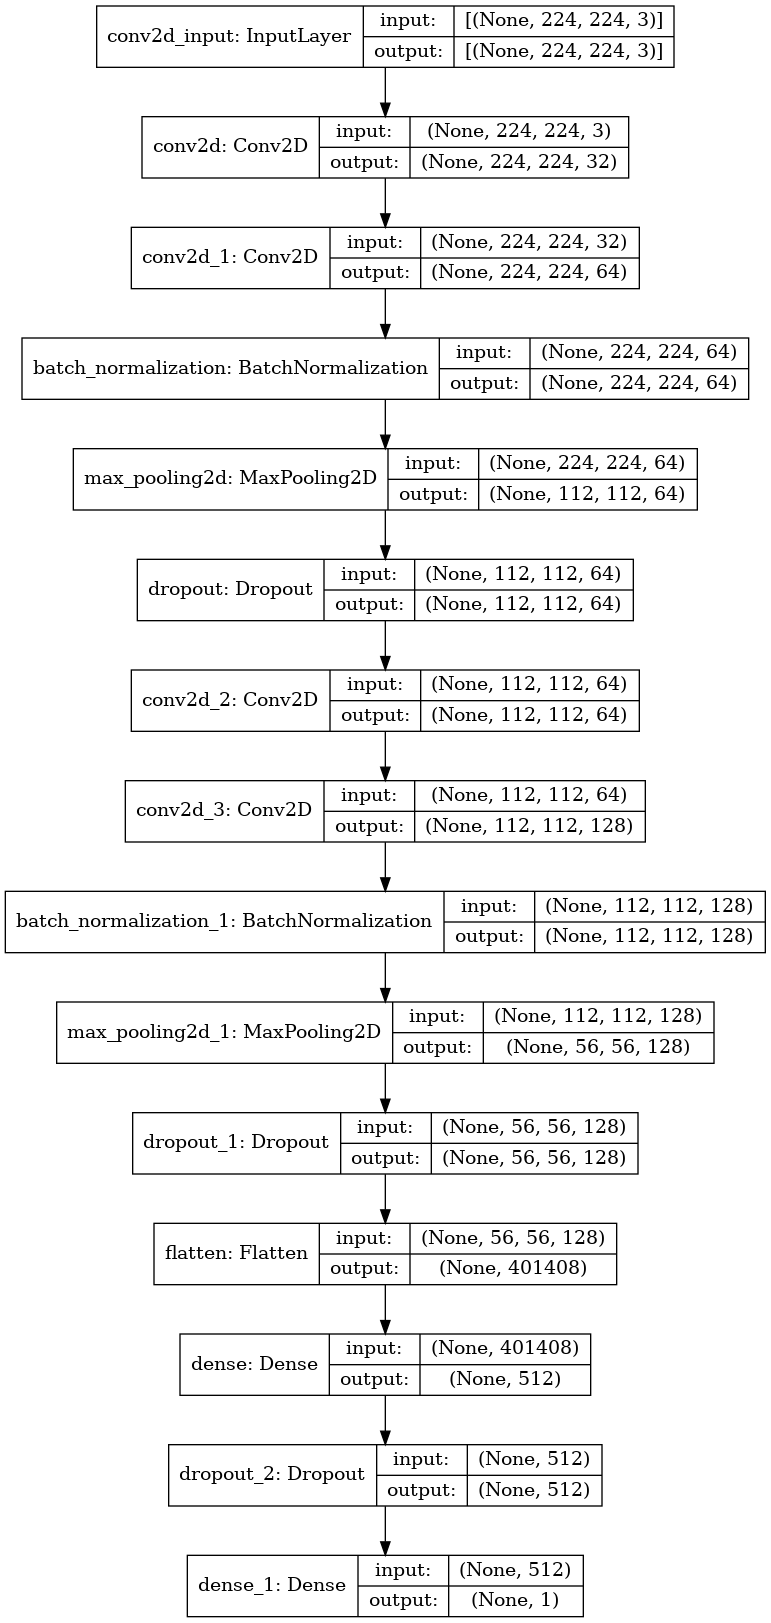

In [46]:
from tensorflow.keras.utils import plot_model

# Plot the model summary
plot_model(model, to_file='model_summary.png', show_shapes=True)

In [49]:
BATCH_SIZE = 32
EPOCHS=100
STEPS_PER_EPOCH = np.ceil(len(X_train[0]/BATCH_SIZE))
print(STEPS_PER_EPOCH)

224.0


In [50]:
history_cus = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=EPOCHS,batch_size=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH,callbacks=[early_stopping,WandbCallback()])

2023-02-17 09:08:24.665104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 09:08:24.665781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 09:08:24.666407: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-02-17 09:08:24.666549: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-02-17 09:08:24.667039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 09:08:24.667496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/100


2023-02-17 09:08:55.470495: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


224/224 [==============================] - 55s 189ms/step - loss: 5.6584 - accuracy: 0.9629 - val_loss: 43.8066 - val_accuracy: 0.7714


2023-02-17 09:09:48.178194: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.
2023-02-17 09:09:49.817239: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.
2023-02-17 09:09:50.846399: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.


Epoch 2/100
224/224 [==============================] - 42s 186ms/step - loss: 0.5831 - accuracy: 0.9928 - val_loss: 44.9447 - val_accuracy: 0.7714
Epoch 3/100
224/224 [==============================] - 10s 43ms/step - loss: 0.7244 - accuracy: 0.9850 - val_loss: 187.2771 - val_accuracy: 0.6286


#### We can see that the difference between accuracy and val_accuracy are very high that means over model is overfitted 

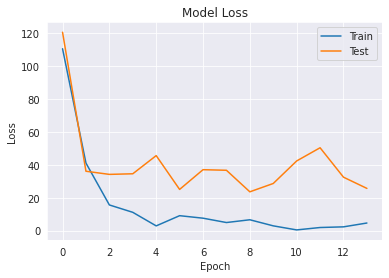

In [67]:
# Plot the loss
import matplotlib.pyplot as plt
plt.plot(history_cus.history['loss'])
plt.plot(history_cus.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper right')
plt.show();

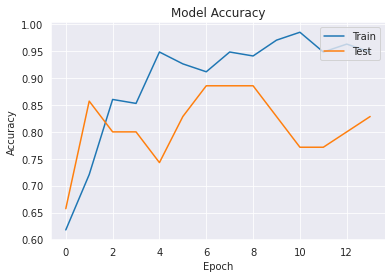

In [68]:
# Plot the Accuracy
import matplotlib.pyplot as plt
plt.plot(history_cus.history['accuracy'])
plt.plot(history_cus.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper right')
plt.show();

In [ ]:
# plot the epochs
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper right')
plt.show();

### Our model (fine_tuned) does not perform well on the image data. We'll optimize our model by

- Re-arraning last CNN architecture
- Train the data using `transfer learning.`

> In this case I will try to experiment more on transfer learning model. 

## Transfer Learning

For this medical task we will be using `VGG16` 

### VGG19 Architecure
*Refer [keras documentation](https://keras.io/api/applications/vgg/#vgg16-function)*

**The VGG16 architecture consists of 16 layers, including 13 convolutional layers and 3 fully connected layers. The architecture is defined by its use of very small (3x3) convolutional filters, which are stacked multiple times to form deep networks.**

In [86]:
vgg16 = tf.keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE 
)

Error in callback <function _WandbInit._resume_backend at 0x7fa990742dd0> (for pre_run_cell):


Exception: The wandb backend process has shutdown

ValueError: `input_shape` must be a tuple of three integers.

Error in callback <function _WandbInit._pause_backend at 0x7fa990742cb0> (for post_run_cell):


Exception: The wandb backend process has shutdown

**Tumors are usually identified as high-intensity regions in the images and Max Pooling helps to retain the highest intensity values from the input and hence, highlight the regions of interest.**

**The Max Pooling layers in the VGG16 model use a pool size of 2x2 with a stride of 2, which reduces the spatial size of the feature maps by a factor of 4.**

In [ ]:
for layer in vgg16.layers:
    layer.trainable = False
    
x = vgg16.output
x = MaxPooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(128,activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

vgg16_model = tf.keras.Model(inputs=vgg16.input, outputs=predictions)

# avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss',patience=10,mode='max')

vgg16_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history_vgg16 = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[early_stopping,WandbCallback()]
)


In [ ]:
# Plot the loss
import matplotlib.pyplot as plt
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper right')
plt.show();